In [1]:
import os 
import time
import random
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import nibabel as nib
import tensorflow as tf
from scipy import ndimage
import matplotlib.pyplot as plt

2023-04-17 19:53:21.844399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 19:53:21.937361: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-17 19:53:21.967307: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-17 19:53:22.675021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
os.getcwd()

'/home/cbasire/Data Mining'

In [3]:
start_path = '/home/cbasire/Data Mining/BSE_BET_DATA/'
image_file_paths = glob(start_path+'files/*')

In [10]:
image_file_paths[0]

'/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI261-HH-1704-T1_bet_04.nii.gz'

In [5]:
# Read nifti file
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath).get_fdata()
    return scan


# Normalize using min-max normalization
def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    return volume.astype("float32")


# Resize image to standard size for all of them
def resize_volume(img):
    depth_factor = 1 / (img.shape[-1] / 64)
    width_factor = 1 / (img.shape[0] / 128)
    height_factor = 1 / (img.shape[1] / 128)
    # Rotate
    img = ndimage.rotate(img, 180, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


# All 3 functions above put in one
def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [11]:
img = process_scan('/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI261-HH-1704-T1_bet_04.nii.gz')

In [13]:
img2 = read_nifti_file('/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI261-HH-1704-T1_bet_04.nii.gz')

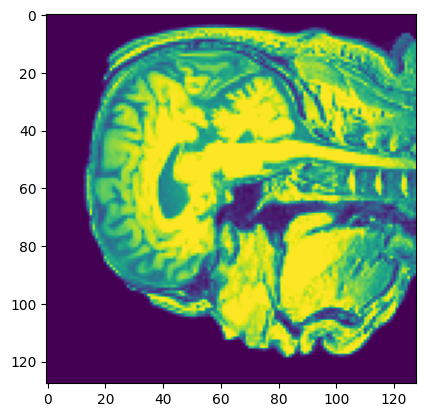

In [12]:
plt.imshow(img[:,:,32])

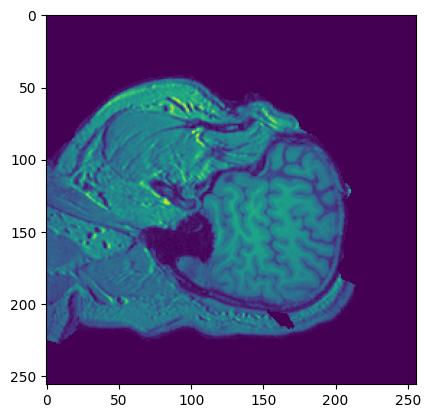

In [14]:
plt.imshow(img2[:,:,32])

In [5]:
data = pd.read_csv(start_path+'labels.csv')

data.head()

,Filename,Recognizable-Facial-Feature,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,Yes,No
1,IXI448-HH-2393-T1_bet_07.nii,Yes,No
2,IXI252-HH-1693-T1_bet_08.nii,Yes,No
3,IXI188-Guys-0798-T1_bet_17.nii,Yes,No
4,IXI182-Guys-0792-T1_bet_17.nii,Yes,No


In [6]:
# Split data into two sets, one for each output variable
df_recognize = data.iloc[: , :-1]
df_brainLoss = data.drop('Recognizable-Facial-Feature', axis=1)

print(df_recognize['Recognizable-Facial-Feature'].value_counts())
print(df_brainLoss['Brain-Feature-Loss'].value_counts())

Recognizable-Facial-Feature
No     1347
Yes     713
Name: count, dtype: int64
Brain-Feature-Loss
Yes    1332
No      728
Name: count, dtype: int64


In [7]:
df_recognize.head()

,Filename,Recognizable-Facial-Feature
0,IXI369-Guys-0924-T1_bet_03.nii,Yes
1,IXI448-HH-2393-T1_bet_07.nii,Yes
2,IXI252-HH-1693-T1_bet_08.nii,Yes
3,IXI188-Guys-0798-T1_bet_17.nii,Yes
4,IXI182-Guys-0792-T1_bet_17.nii,Yes


In [8]:
df_brainLoss.head()

,Filename,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,No
1,IXI448-HH-2393-T1_bet_07.nii,No
2,IXI252-HH-1693-T1_bet_08.nii,No
3,IXI188-Guys-0798-T1_bet_17.nii,No
4,IXI182-Guys-0792-T1_bet_17.nii,No


In [9]:
df_recognize['Recognizable-Facial-Feature'] = df_recognize['Recognizable-Facial-Feature'].replace({'Yes': 1, 'No': 0})

df_brainLoss['Brain-Feature-Loss'] = df_brainLoss['Brain-Feature-Loss'].replace({'Yes': 1, 'No': 0})


/local_scratch/pbs.495250.pbs02/ipykernel_842255/3476586761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recognize['Recognizable-Facial-Feature'] = df_recognize['Recognizable-Facial-Feature'].replace({'Yes': 1, 'No': 0})


In [10]:
df_recognize.head()

,Filename,Recognizable-Facial-Feature
0,IXI369-Guys-0924-T1_bet_03.nii,1
1,IXI448-HH-2393-T1_bet_07.nii,1
2,IXI252-HH-1693-T1_bet_08.nii,1
3,IXI188-Guys-0798-T1_bet_17.nii,1
4,IXI182-Guys-0792-T1_bet_17.nii,1


In [11]:
df_brainLoss.head()

,Filename,Brain-Feature-Loss
0,IXI369-Guys-0924-T1_bet_03.nii,0
1,IXI448-HH-2393-T1_bet_07.nii,0
2,IXI252-HH-1693-T1_bet_08.nii,0
3,IXI188-Guys-0798-T1_bet_17.nii,0
4,IXI182-Guys-0792-T1_bet_17.nii,0


In [12]:
image_file_paths[0].index('IXI')

45

### arranging list of paths as in the order of labels

In [13]:
df_recognize_paths = []
for filename in df_recognize['Filename']:
    for path in image_file_paths:
        # Check if path is a Yes file or a No fi
        if path[45:-3:] == filename:
            df_recognize_paths.append(glob(path))

In [14]:
df_recognize_paths[:5]

[['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI369-Guys-0924-T1_bet_03.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI448-HH-2393-T1_bet_07.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI252-HH-1693-T1_bet_08.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI188-Guys-0798-T1_bet_17.nii.gz'],
 ['/home/cbasire/Data Mining/BSE_BET_DATA/files/IXI182-Guys-0792-T1_bet_17.nii.gz']]

In [15]:
df_recognize['Filename'][:5]

0    IXI369-Guys-0924-T1_bet_03.nii
1      IXI448-HH-2393-T1_bet_07.nii
2      IXI252-HH-1693-T1_bet_08.nii
3    IXI188-Guys-0798-T1_bet_17.nii
4    IXI182-Guys-0792-T1_bet_17.nii
Name: Filename, dtype: object

In [16]:
np_X_data_rotate = np.array([process_scan(path[0]) for path in tqdm(df_recognize_paths)]) # processing each file

100%|██████████| 2060/2060 [42:43<00:00,  1.24s/it]


In [17]:
Y_recognize_rotate = df_recognize.iloc[:,-1].to_numpy()

In [18]:
Y_feature_rotate = df_brainLoss.iloc[:,-1].to_numpy()

In [19]:
with open('np_X_data_rotate.pickle', 'wb') as f:
    pickle.dump(np_X_data_rotate, f)
with open('Y_recognize_rotate.pickle', 'wb') as f:
    pickle.dump(Y_recognize_rotate, f)
with open('Y_feature_rotate.pickle', 'wb') as f:
    pickle.dump(Y_feature_rotate, f)